# Paper Plot R2, Profile, Cross-section

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.utils import read_ancilaries, find_closest_value, find_closest_longitude  # , get_pressure
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
from neural_networks.cbrain.cam_constants import *
import matplotlib.pyplot as plt
import gc
import pickle
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cmocean
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-04-13 14:09:20.540741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [6]:
font_size = 13

In [52]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"


In [53]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

training_run = "training_91_mask_net_prediction_thresholds_spars0.001"
base_dir = os.path.join(PROJECT_ROOT, "output_castle", training_run )
plots_dir = os.path.join(base_dir, "plots_offline_evaluation")
outputs_list_file = os.path.join(base_dir, "outputs_list.txt")

if "prediction_thresholds" in base_dir:
    train_val = "_train"
else: 
    train_val = ""

cfg = os.path.join(base_dir, "cfg_mask_net.yml")

output_dir = os.path.join(base_dir, "plots_offline_evaluation", "plots_paper" + train_val)
Path(output_dir).mkdir(parents=True, exist_ok=True)

ANCIL_FILE = os.path.join(Path.cwd().parent.resolve(), "data", "ancil_spcam.nc")

In [54]:
def load_pickle(f_name):
    with open(f_name, "rb") as f:
        values = pickle.load(f)
    return values

In [55]:
def parse_txt_to_list(txt_file):
    line_list = list()
    with open(txt_file, 'r') as f:
        for line in f:
            line_list.append(line.rstrip())
    return line_list

In [56]:
causal_plot_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                          "models_arch-rasp_thrs-opt-mse6", "plots_offline_evaluation")


In [66]:
variable = "phq" # tphystnd, phq 
stats = "r2"

In [67]:
save_formats = ["pdf", "svg"]

## Plot Profiles

In [68]:
profile_dir = os.path.join(plots_dir, "plots_profiles" + train_val, f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")
causal_profile_dir = os.path.join(causal_plot_dir, "plots_profiles", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

In [69]:
profiles = dict()

profiles["truth"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_truth.p"))
profiles["pred"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_pred.p"))
profiles[stats] = load_pickle(os.path.join(profile_dir, f"{variable}_stats-{stats}.p"))

In [70]:
causal_profiles = dict()

causal_profiles["truth"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_truth.p"))
causal_profiles["pred"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_pred.p"))
causal_profiles[stats] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_stats-{stats}.p"))

In [71]:
outputs_list = parse_txt_to_list(outputs_list_file)

In [75]:

def plot_profile_r2(ax1): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    arr_truth = np.mean(profiles["truth"], axis=0)
    arr_pred = np.mean(profiles["pred"], axis=0)
    arr_causal_pred = np.mean(causal_profiles["pred"], axis=0)

    last_neg_index = 10
    if variable == "phq": 
        line_truth, = ax1.plot(arr_truth[last_neg_index + 1:], 
                               P[last_neg_index + 1:], label="SPCAM", color=blue)
        line_pred, = ax1.plot(arr_pred[last_neg_index + 1:], 
                              P[last_neg_index + 1:], label="Prediction PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred[last_neg_index + 1:], 
                                     P[last_neg_index + 1:], label="Prediction CI-NN", linestyle="dotted", color=blue)
    
    else: 
        line_truth, = ax1.plot(arr_truth, P, label="SPCAM", color=blue)
        line_pred, = ax1.plot(arr_pred, P, label="Prediction PCM", linestyle="dashed", color=blue)
        line_pred_causal, = ax1.plot(arr_causal_pred, P, label="Prediction CI-NN", linestyle="dotted", color=blue)

    ax1.set_xlim(vmin, vmax)
    ax1.set_ylim(P[0], P[-1])

    ax1.tick_params(bottom=True, left=True, length=2)
    ax1.tick_params(axis='x', labelsize=font_size)
    ax1.tick_params(axis='y', labelsize=font_size)


    ax1.set_yticks([200, 400, 600, 800])
    
    ax1.set_xlabel(f'{var_label[variable]} ({units[variable]})', color=blue)
    ax1.tick_params(axis='x', colors=blue) 
    
    ax1.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax1.invert_yaxis()
    
    # Set the Y-axis labels
    # ax1.set_yticks([1000, 600, 300, 0])
    
    # Create a secondary X-axis (top)
    ax2 = ax1.twiny()  # Share the same Y-axis

    arr = np.mean(profiles[stats], axis=1)
    arr_causal = np.mean(causal_profiles[stats], axis=1)

    if variable == "phq": 
        # last_neg_index = np.where(arr< 0)[0][-1]
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label=r"$R^2$ CI-NN",
                                   linestyle="dotted", color=red)  
    else:     
        line_r2, = ax2.plot(arr, P, label=r"$R^2$ PCM", color=red)  
        line_r2_causal, = ax2.plot(arr_causal, P, label=r"$R^2$ CI-NN",linestyle="dotted", color=red)  
    
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score', color=red)
    ax2.tick_params(axis='x', colors=red)  # Set color of ticks and labels to red
    
    ax2.spines['top'].set_color(red)  
    ax2.spines['bottom'].set_color(blue)
    
    # ax1.set_ylabel('Pressure (hPa)', labelpad=15, color='#333333')
    # ax1.set_xlabel(f"{s}", labelpad=15, color='#333333')
    ax1.set_rasterized(True)
    ax2.set_rasterized(True)

    if variable == "phq":
        loc = "upper left"
    else: 
        loc = "center left"
    
    plt.legend(handles=[line_truth, line_pred, line_pred_causal, line_r2, line_r2_causal], 
               prop={'size': 12}, loc=loc)



In [76]:
def save_figures(file_name):
    for format in save_formats:        
        f_path = os.path.join(output_dir, f"{variable}_{file_name}.{format}")

        fig.savefig(f_path, format=format, bbox_inches="tight", transparent=True)
    
        print(f"\nSaved figure {f_path}")


Last negative index: 10 (phq-142.99)
Start plot from index 11 (phq-168.23)

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_profile_r2_cutoff_168.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_profile_r2_cutoff_168.svg


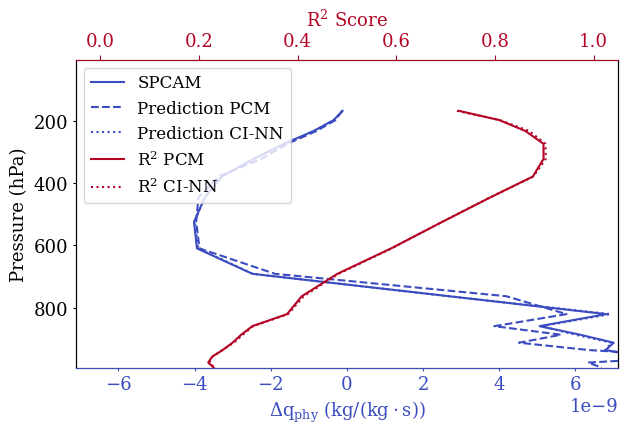

In [77]:
plt.close()

fig, ax1 = plt.subplots(figsize=(7, 4))
plot_profile_r2(ax1)

if variable == "phq":
    f_name = "profile_r2_cutoff_168"
else: 
    f_name = "profile_r2"

save_figures(f_name)

plt.show()

## Plot Cross-sections

In [78]:
cross_section_dir = os.path.join(plots_dir, "plots_cross_section" + train_val, f"mean-all_stats-{stats}_no_diff")

In [79]:
cross_sections = dict()

cross_sections["truth"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_truth.p"))
cross_sections["pred"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_pred.p"))
cross_sections[stats] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_stats-{stats}.p"))

In [80]:

def plot_cross_section(ax, truth_or_pred, v_name, set_title=True):
    
    vmin = np.min([np.min(cross_sections["pred"]), np.min(cross_sections["truth"])])
    vmax = np.max([np.max(cross_sections["pred"]), np.max(cross_sections["truth"])])
    
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    extend = None
    
    cThemes = {'tphystnd': 'RdBu', 'phq': 'RdBu'}
    cmap = cThemes[v_name]

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    
    # I = ax.imshow(cross_sections[truth_or_pred], vmin=vmin, vmax=vmax, cmap=cmap, interpolation="gaussian")
    I = ax.pcolormesh(latitudes, P, cross_sections[truth_or_pred], vmin=vmin, vmax=vmax, cmap=cmap)
    ax.invert_yaxis()

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    # lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    ax.set_xlabel('Latitude')

    # pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    # pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    # ax.set_yticks(pressure_ticks)
    # ax.set_yticklabels(pressure_label)
    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')

    # cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    # cb.set_label('')
    #  (left, bottom, width, height)
    cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.16,
                        ax.get_position().width,  0.03])
    cb = fig.colorbar(I, cax=cax, orientation='horizontal', extend=extend)
    cb.set_label('')

    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    if set_title:
        if truth_or_pred == "truth":
            ax.set_title(f"SPCAM Truth {var_label[variable]}", fontsize=font_size)
        else: 
            ax.set_title(f"PCMasking Prediction {var_label[variable]}", fontsize=font_size)

    ax.set_rasterized(True)
    






Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_pred.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_pred.svg


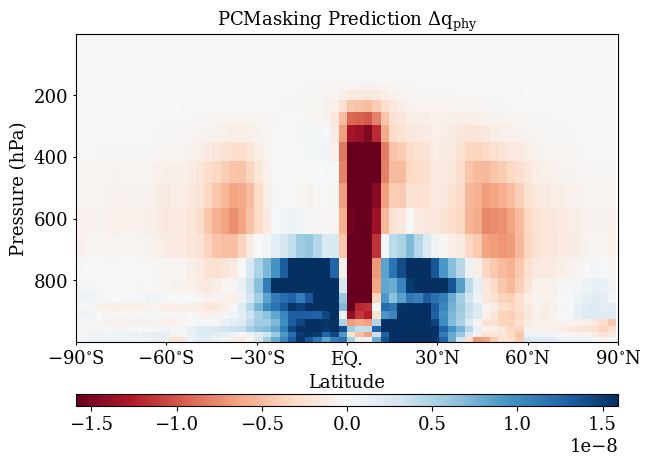

In [81]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "pred", variable)

save_figures("cross_section_pred")

plt.show()


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_truth.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_truth.svg


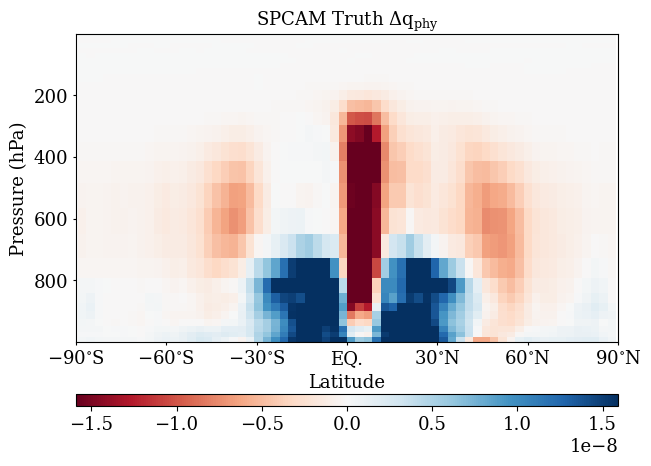

In [82]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "truth", variable)

save_figures("cross_section_truth")

plt.show()

## Plot R2

In [83]:
import copy

In [84]:

def plot_cross_section_r2(ax, set_title=True):
    vmin = 0.;
    vmax = 1.
    extend = 'min'
    cmap = 'Reds'

    stats_plot = copy.deepcopy(cross_sections[stats])

    if variable == "phq": 
        last_neg_index = 10
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")

        stats_plot[0:last_neg_index + 1, :,] = -np.inf

        
    # I = ax.imshow(cross_sections[stats][:-last_neg_index, :], vmin=vmin, vmax=vmax, cmap=cmap)
    # I = ax.imshow(stats_plot, vmin=vmin, vmax=vmax, cmap=cmap)
    
    # cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    # cb.set_label('')
    
    # levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))
    # pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    # pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    # ax.set_yticks(pressure_ticks)
    # ax.set_yticklabels(pressure_label)
    # ax.set_ylabel('Pressure (hPa)')
    
    # lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    # lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    # ax.set_xticks(lat_ticks)
    # ax.set_xticklabels(lat_labels)
    # ax.set_xlabel('Latitude')
    
    # ax.set_rasterized(True)

    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))

    
    I = ax.pcolormesh(latitudes, P, stats_plot, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.invert_yaxis()

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    # lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    ax.set_xticklabels([r"$-90^{\circ}$S",  r"$-60^{\circ}$S", r"$-30^{\circ}$S", r"EQ.", 
                        r"$30^{\circ}$N", r"$60^{\circ}$N", r"$90^{\circ}$N"])
    ax.set_xlabel('Latitude')

    # pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    # pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    # ax.set_yticks(pressure_ticks)
    # ax.set_yticklabels(pressure_label)
    ax.set_yticks([200, 400, 600, 800])
    ax.set_ylabel('Pressure (hPa)')

    # cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    # cb.set_label('')
    #  (left, bottom, width, height)
    cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.16,
                        ax.get_position().width,  0.03])
    cb = fig.colorbar(I, cax=cax, orientation='horizontal', extend=extend)
    cb.set_label('')
    

    if set_title:
        ax.set_title(r"$R^{2}$ Score", fontsize=font_size)

    ax.set_rasterized(True)
   

Last negative index: 10 (phq-142.99)

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_r2_cutoff_168.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_r2_cutoff_168.svg


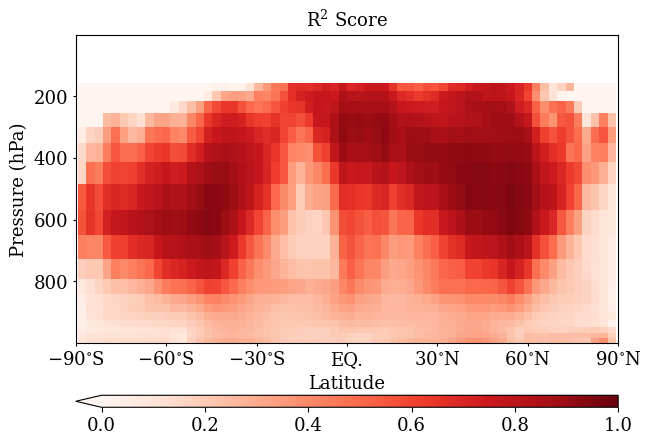

In [85]:
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))
plot_cross_section_r2(ax)

if variable == "phq":
    f_name = "cross_section_r2_cutoff_168"
else: 
    f_name = "cross_section_r2"

save_figures(f_name)
 
plt.show()

## Plot all

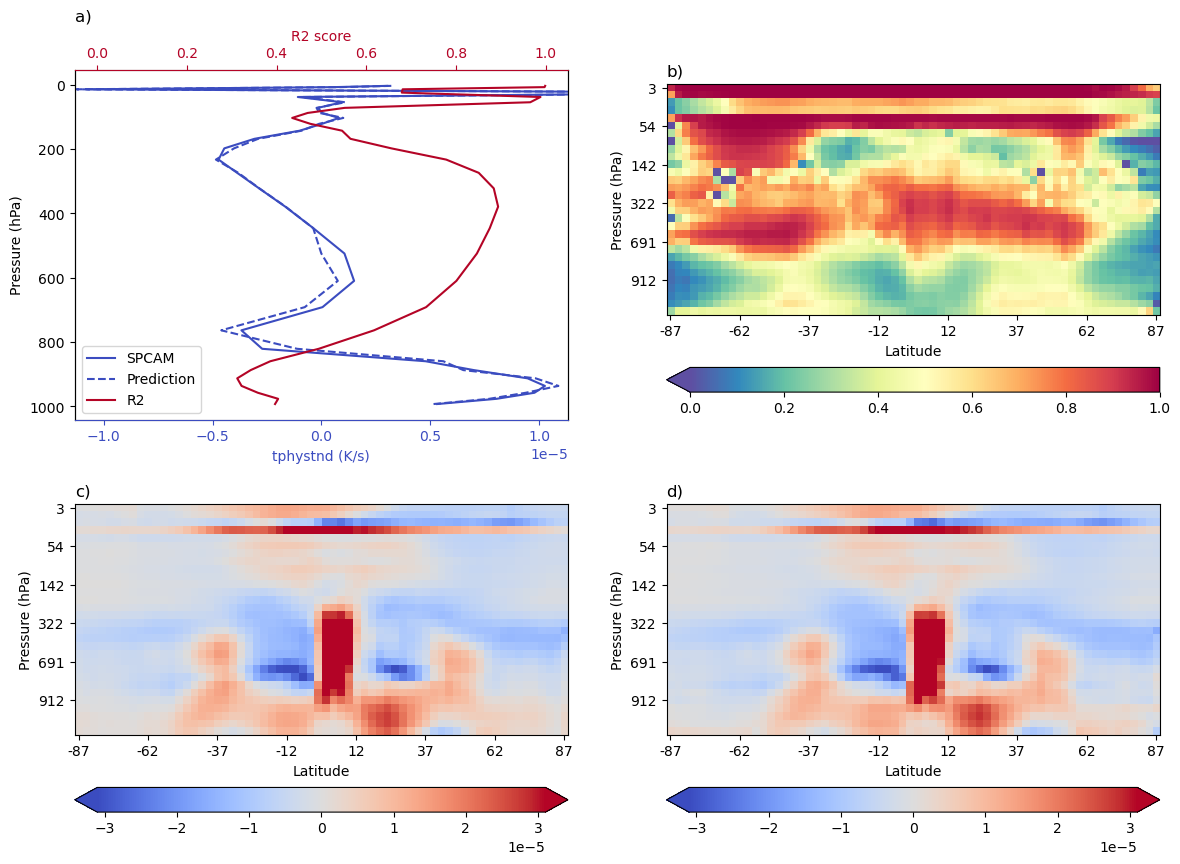

In [20]:
plt.close()

fig, axs = plt.subplots(2, 2,  figsize=(14, 10))
# fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)']],
#                               layout='constrained', 
#                               figsize=(14, 10))

plot_profile_r2(axs[0, 0])
axs[0, 0].set_title("a)", fontsize="large", loc="left")

plot_cross_section_r2(axs[0, 1])
axs[0, 1].set_title("b)", fontsize="large", loc="left")

plot_cross_section(axs[1, 0], "truth", variable)
axs[1, 0].set_title("c)", fontsize="large", loc="left")

plot_cross_section(axs[1, 1], "pred", variable)
axs[1, 1].set_title("d)", fontsize="large", loc="left")


plt.show()


## Plot Snapshots

In [47]:
step = 500
cross_section_dir = os.path.join(plots_dir, "plots_cross_section" + train_val, f"step-{step}_no_diff")

In [48]:
cross_sections = dict()

cross_sections["truth"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_truth.p"))
cross_sections["pred"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_pred.p"))

In [49]:
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_truth_snap_shot_step_500.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_truth_snap_shot_step_500.svg


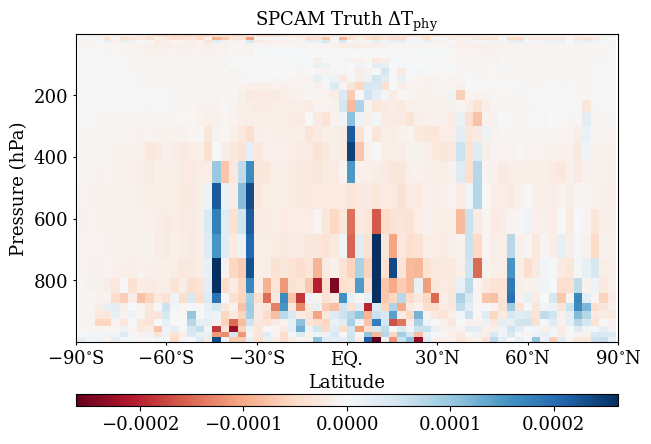

In [50]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "truth", variable)

f_name = f"cross_section_truth_snap_shot_step_{step}"
save_figures(f_name)




Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_pred_snap_shot_step_500.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_cross_section_pred_snap_shot_step_500.svg


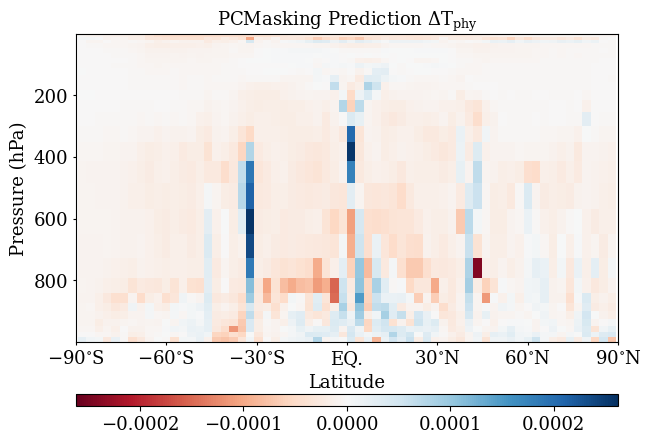

In [51]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 4))

plot_cross_section(ax, "pred", variable)

f_name = f"cross_section_pred_snap_shot_step_{step}"
save_figures(f_name)


## Tuning Results

In [300]:
tuning_dirs = ["training_88_mask_net_prediction_thresholds_spars1.0", 
        "training_89_mask_net_prediction_thresholds_spars0.1",
        "training_90_mask_net_prediction_thresholds_spars0.01",
        "training_91_mask_net_prediction_thresholds_spars0.001",
        "training_92_mask_net_prediction_thresholds_spars1e-4",
        "training_93_mask_net_prediction_thresholds_spars1e-5", 
]
train_val = "train"


In [301]:
labels = [r"$\lambda_{spars} = 1.0$", 
          r"$\lambda_{spars} = 0.1$", 
          r"$\lambda_{spars} = 0.01$", 
          r"$\lambda_{spars} = 0.001$", 
          r"$\lambda_{spars} = 10^{-4}$", 
          r"$\lambda_{spars} = 10^{-5}$"
         ]

In [310]:
variable = "tphystnd" # tphystnd, phq 
stats = "r2"

In [311]:
causal_plot_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                          "models_arch-rasp_thrs-opt-mse6", "plots_offline_evaluation")
causal_profile_dir = os.path.join(causal_plot_dir, "plots_profiles", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

In [312]:
causal_profiles = dict()

causal_profiles["truth"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_truth.p"))
causal_profiles["pred"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_pred.p"))
causal_profiles[stats] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_stats-{stats}.p"))

In [313]:
profiles_tuning = {d: dict() for d in tuning_dirs}

for d in tuning_dirs:
    bd = os.path.join(PROJECT_ROOT, "output_castle", d )
    plots_dir = os.path.join(bd, "plots_offline_evaluation")
    outputs_list_file = os.path.join(bd, "outputs_list.txt")

    profile_dir = os.path.join(plots_dir, f"plots_profiles_{train_val}", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")
    
    cfg = os.path.join(bd, "cfg_mask_net.yml")
    outputs_list = parse_txt_to_list(outputs_list_file)

    
    profiles_tuning[d]["truth"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_truth.p"))
    profiles_tuning[d]["pred"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_pred.p"))
    profiles_tuning[d][stats] = load_pickle(os.path.join(profile_dir, f"{variable}_stats-{stats}.p"))

In [314]:
ref =  "training_91_mask_net_prediction_thresholds_spars0.001"

In [315]:
output_dir = os.path.join(PROJECT_ROOT, "output_castle", ref, 
                          "plots_offline_evaluation", 
                          f"plots_paper_{train_val}_tuning")


In [318]:
def plot_tuning_profiles(fig, ax):
    
    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    vmin = np.min([np.min(profiles_tuning[ref]["pred"]), np.min(profiles_tuning[ref]["truth"])])
    vmax = np.max([np.max(profiles_tuning[ref]["pred"]), np.max(profiles_tuning[ref]["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    colors  = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

    last_neg_index = 10
    #######################
    # Plot Pred
    lines_pred = list()
    
    for i, d in enumerate(tuning_dirs): 
        arr = np.mean(profiles_tuning[d]["pred"], axis=0)
        if variable == "phq": 
            print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
            print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

            l, = ax.plot(arr[last_neg_index + 1:], P[last_neg_index + 1:], label=labels[i], color=colors[i])
        else: 
            l, = ax.plot(arr, P, label=labels[i], color=colors[i])
            
        lines_pred.append(l)

    if variable == "phq":
        line_truth, = ax.plot(np.mean(profiles_tuning[ref]["truth"], axis=0)[last_neg_index + 1], 
                              P[last_neg_index + 1], label="SPCAM", color=colors[i+1])
        line_pred_causal, = ax.plot(np.mean(causal_profiles["pred"], axis=0)[last_neg_index + 1], 
                                    P[last_neg_index + 1], label="CI-NN", 
                                    linestyle="dotted", color=colors[i+2])
        
    else:
        line_truth, = ax.plot(np.mean(profiles_tuning[ref]["truth"], axis=0), P, label="SPCAM", color=colors[i+1])
        line_pred_causal, = ax.plot(np.mean(causal_profiles["pred"], axis=0), P, label="CI-NN", 
                                     linestyle="dotted", color=colors[i+2])

    ax.set_ylim(P[0], P[-1])
    ax.set_xlim(vmin, vmax)

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)


    ax.set_yticks([200, 400, 600, 800])
    
    ax.set_xlabel(f'{var_label[variable]} ({units[variable]})')
    
    ax.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax.invert_yaxis()
    ax.set_rasterized(True)

    ax.set_title("Tuning Predictions", fontsize=font_size)

    if variable == "phq":
        plt.legend(prop={'size': 12}, loc="upper right")
    else: 
        plt.legend(prop={'size': 12}, loc="center right")


    #######################
    # Plot R2
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("right", size="100%", pad=.15, sharey=ax)

    for i, d in enumerate(tuning_dirs): 
        arr = np.mean(profiles_tuning[d][stats], axis=1)

        if variable == "phq": 
            print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
            print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")
    
            line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=labels[i], color=colors[i])  
        else:     
            line_r2, = ax2.plot(arr, P, label=labels[i], color=colors[i])

    
    arr_causal = np.mean(causal_profiles[stats], axis=1)
    if variable == "phq":
        line_r2_causal, = ax2.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label="CI-NN",
                                   linestyle="dotted", color=colors[i+2])  
    else:             
        line_r2_causal, = ax2.plot(arr_causal, P, label="CI-NN",linestyle="dotted", color=colors[i+2])  

    ax2.tick_params(bottom=True, left=True, length=2)
    ax2.tick_params(axis='x', labelsize=font_size)
    ax2.tick_params(axis='y', labelsize=font_size, labelleft=False)

    ax2.set_xlabel(f'{var_label[variable]} ({units[variable]})')
    
    # ax.set_ylabel('Pressure (hPa)')
  
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score')
    
    ax2.set_rasterized(True)
    
    
    ax2.set_title(f"Tuning $R^{2}$ Scores", fontsize=font_size)

    # plt.legend(prop={'size': 12}, loc="center left")

   


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/tphystnd_tuning_profiles.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/tphystnd_tuning_profiles.svg


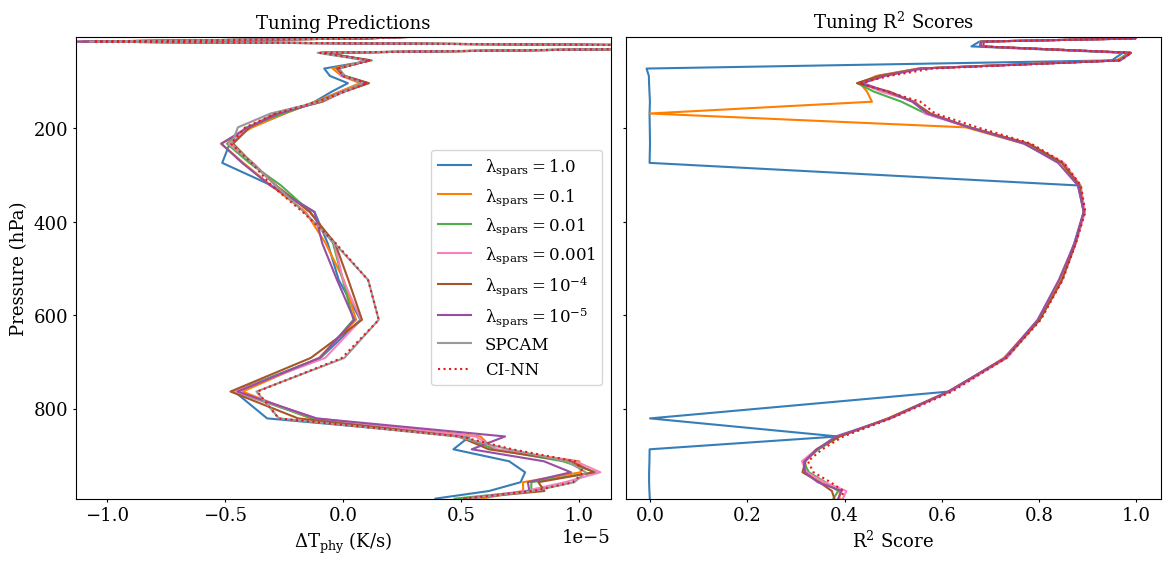

In [319]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_tuning_profiles(fig, ax)

if variable == "phq":
    f_name = "tuning_profiles_cutoff_168"
else: 
    f_name = "tuning_profiles"

save_figures(f_name)


In [86]:
plt.close()

In [118]:
def plot_tuning_r2(fig, ax):


    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    colors  = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    lines_pred = list()

    last_neg_index = 10
    for i, d in enumerate(tuning_dirs): 
        arr = np.mean(profiles_tuning[d][stats], axis=1)

        if variable == "phq": 
            print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
            print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")
    
            line_r2, = ax.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=labels[i], color=colors[i])  
        else:     
            line_r2, = ax.plot(arr, P, label=labels[i], color=colors[i])  

    
    arr_causal = np.mean(causal_profiles[stats], axis=1)
    if variable == "phq":
        line_r2_causal, = ax.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label="CI-NN",
                                   linestyle="dotted", color=colors[i+2])  
    else:             
        line_r2_causal, = ax.plot(arr_causal, P, label="CI-NN",linestyle="dotted", color=colors[i+2])  

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)


    ax.set_yticks([200, 400, 600, 800])
    empty_string_labels = [''] * len([200, 400, 600, 800])
    ax.set_yticklabels(empty_string_labels)
    
    ax.set_xlabel(f'{var_label[variable]} ({units[variable]})')
    
    # ax.set_ylabel('Pressure (hPa)')
  
    ax.set_xlim(-0.05, 1.05)
    ax.set_xlabel(r'$R^2$ Score')
    
    ax.set_rasterized(True)
    
    
    ax.set_title(f"Tuning $R^{2}$ Scores", fontsize=font_size)

    plt.legend(prop={'size': 12}, loc="center left")


FigureCanvasAgg is non-interactive, and thus cannot be shown


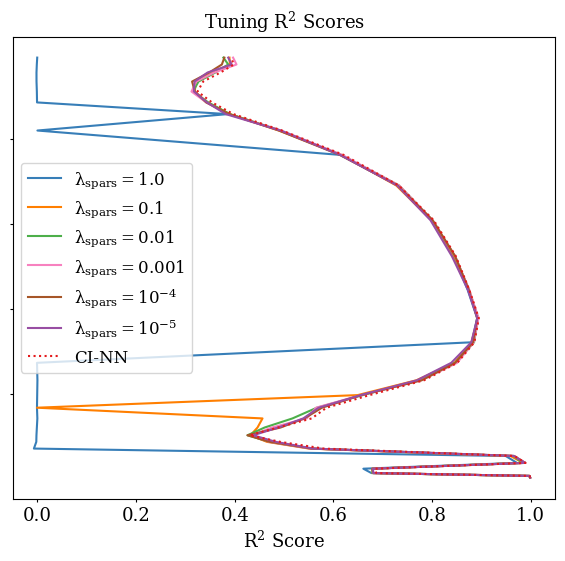

In [119]:
fig, ax = plt.subplots(figsize=(7, 6))

plot_tuning_r2(fig, ax)

fig.show()